# Imports

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torcheval.metrics import MulticlassAccuracy
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Check if CUDA (GPU) is available and set the device accordingly.
device = "cuda" if torch.cuda.is_available() else "cpu"

# For some reason, using the GPU is much slower than CPU
device = 'cpu'

print(f"Using device: {device}")

Using device: cpu


# Data Loading

In [3]:
# Set up the label encoder for consistency in target labels
le = LabelEncoder()
labels = ['Benign', 'DDoS', 'Reconnaissance', 'Brute Force', 'password', 'xss', 'Backdoor']
le.fit(labels)

LabelEncoder()

In [4]:
class NFUQNIDS(Dataset):
    def __init__(self, attacks, use_reduced, use_synthetic):
        self.data = pd.DataFrame()

        for attack in attacks:
            if use_reduced:
                temp = pd.read_csv(f'data/reduced/attacks/NF-UQ-NIDS-ATTACKS-{str.upper(attack)}.csv')
                if self.data.empty:
                    self.data = temp.copy()
                else:
                    self.data = pd.concat([self.data, temp], ignore_index=True)
            else:
                temp = pd.read_csv(f'data/cleaned/attacks/NF-UQ-NIDS-ATTACKS-{str.upper(attack)}.csv')
                if self.data.empty:
                    self.data = temp.copy()
                else:
                    self.data = pd.concat([self.data, temp], ignore_index=True)

            if use_synthetic:
                    if os.path.exists(f'data/synthetic/NF-UQ-NIDS-ATTACKS-{str.upper(attack)}-SYNTHETIC.csv'):
                        temp = pd.read_csv(f'data/synthetic/NF-UQ-NIDS-ATTACKS-{str.upper(attack)}-SYNTHETIC.csv')
                        if self.data.empty:
                            self.data = temp.copy()
                        else:
                            self.data = pd.concat([self.data, temp], ignore_index=True)

        # Attack type as target label
        self.labels = self.data['Attack']
        self.labels = le.transform(self.labels)

        self.data.drop({'Attack', 'Label'}, axis=1, inplace=True, errors='ignore')

        self.data = self.data.values

        print(self.data)
        print(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = torch.tensor(self.data[idx], dtype=torch.float32, device=device)
        label = torch.tensor(self.labels[idx], dtype=torch.float32, device=device)
        label = label.type(torch.LongTensor).to(device)

        return features, label

In [5]:
# Real attack data
real_attack_data = NFUQNIDS({'DDoS', 'Reconnaissance', 'Brute Force', 'Password', 'XSS', 'Backdoor'}, use_reduced=True, use_synthetic=False)

train_size = int(0.9 * len(real_attack_data))
val_size = len(real_attack_data) - train_size
real_train_dataset, real_val_dataset = torch.utils.data.random_split(real_attack_data, [train_size, val_size])

# Synthetic attack data
synth_attack_data = NFUQNIDS({'DDoS', 'Reconnaissance', 'Brute Force', 'Password', 'XSS', 'Backdoor'}, use_reduced=True, use_synthetic=True)

train_size = int(0.9 * len(synth_attack_data))
val_size = len(synth_attack_data) - train_size
synth_train_dataset, synth_val_dataset = torch.utils.data.random_split(synth_attack_data, [train_size, val_size])

[[5.7966e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [5.8024e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [3.3420e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 ...
 [6.4202e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [6.0902e+04 8.0000e+01 6.0000e+00 ... 1.0000e+00 1.0000e+00 0.0000e+00]
 [4.5930e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]]
[5 5 5 ... 3 3 3]
[[5.7966e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [5.8024e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [3.3420e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 ...
 [6.4202e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [6.0902e+04 8.0000e+01 6.0000e+00 ... 1.0000e+00 1.0000e+00 0.0000e+00]
 [4.5930e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]]
[5 5 5 ... 3 3 3]


In [6]:
batch_size = 4096

real_train = DataLoader(real_train_dataset, batch_size=batch_size, shuffle=True)
real_val = DataLoader(real_val_dataset, batch_size=batch_size, shuffle=True)

synth_train = DataLoader(synth_train_dataset, batch_size=batch_size, shuffle=True)
synth_val = DataLoader(synth_val_dataset, batch_size=batch_size, shuffle=True)

del real_train_dataset
del real_val_dataset
del synth_train_dataset
del synth_val_dataset

# Model Definition

In [7]:
# Model hyperparameters
input_dim = 74
hidden_dim = input_dim*2
num_classes = len(labels)

# Model definition
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Model Training

## Synthetic-Boosted Model

In [35]:
# Train the synthetic-boosted model
synth_model = Classifier(input_dim, hidden_dim, num_classes).to(device)

# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(synth_model.parameters(), lr=0.001)

num_epochs = 100

# Lists to store the loss values for training and validation sets
synth_train_loss_list = []
synth_val_loss_list = []
synth_real_loss_list = []

for epoch in tqdm(range(num_epochs)):
    cumulative_train_loss = 0
    cumulative_val_loss = 0
    cumulative_real_loss = 0

    for inputs, labels in synth_train:
        # Calculate training output and loss
        train_outputs = synth_model(inputs)
        train_loss = criterion(train_outputs, labels)

        cumulative_train_loss = cumulative_train_loss + train_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
    # Calculate training loss this epoch
    cumulative_train_loss = cumulative_train_loss.item() / (len(synth_train))
    synth_train_loss_list.append(cumulative_train_loss)

    synth_model.eval()
    with torch.no_grad():
        for inputs, labels in synth_val:
            # Calculate val output and loss
            val_outputs = synth_model(inputs)
            val_loss = criterion(val_outputs, labels)

        cumulative_val_loss = cumulative_val_loss + val_loss

        for inputs, labels in real_val:
            # Calculate real output and loss
            real_outputs = synth_model(inputs)
            real_loss = criterion(real_outputs, labels)

        cumulative_real_loss = cumulative_real_loss + real_loss
    

    # Calculate val loss this epoch
    cumulative_val_loss = cumulative_val_loss.item() / (len(synth_val))
    synth_val_loss_list.append(cumulative_val_loss)

    # Calculate real loss this epoch
    cumulative_real_loss = cumulative_real_loss.item() / (len(real_val))
    synth_real_loss_list.append(cumulative_real_loss)

    if(((epoch+1) % 10) == 0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {(cumulative_train_loss):.4f}, Validation Loss: {(cumulative_val_loss):.4f}, Real Loss: {(cumulative_real_loss):.4f}')

 10%|█         | 10/100 [01:11<10:38,  7.10s/it]

Epoch [10/100], Train Loss: 385.4822, Validation Loss: 79.7176, Real Loss: 62.9768


 20%|██        | 20/100 [02:23<09:37,  7.22s/it]

Epoch [20/100], Train Loss: 257.8730, Validation Loss: 32.1523, Real Loss: 14.7750


 30%|███       | 30/100 [03:36<08:31,  7.31s/it]

Epoch [30/100], Train Loss: 69.8823, Validation Loss: 8.3879, Real Loss: 7.9473


 40%|████      | 40/100 [04:51<07:31,  7.53s/it]

Epoch [40/100], Train Loss: 62.4657, Validation Loss: 1.6173, Real Loss: 8.6282


 50%|█████     | 50/100 [06:07<06:28,  7.76s/it]

Epoch [50/100], Train Loss: 33.5092, Validation Loss: 3.7622, Real Loss: 4.4634


 60%|██████    | 60/100 [07:21<04:45,  7.15s/it]

Epoch [60/100], Train Loss: 24.7516, Validation Loss: 10.3884, Real Loss: 9.9361


 70%|███████   | 70/100 [08:33<03:31,  7.06s/it]

Epoch [70/100], Train Loss: 2.0219, Validation Loss: 0.5855, Real Loss: 0.4228


 80%|████████  | 80/100 [09:51<02:39,  7.96s/it]

Epoch [80/100], Train Loss: 11.4525, Validation Loss: 0.5901, Real Loss: 0.5980


 90%|█████████ | 90/100 [11:04<01:10,  7.06s/it]

Epoch [90/100], Train Loss: 15.6123, Validation Loss: 5.0848, Real Loss: 6.0885


100%|██████████| 100/100 [12:11<00:00,  7.32s/it]

Epoch [100/100], Train Loss: 1.2435, Validation Loss: 0.1775, Real Loss: 0.2189


## Real-Only Model

In [9]:
# Train the real-only model
real_model = Classifier(input_dim, hidden_dim, num_classes).to(device)

# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(real_model.parameters(), lr=0.001)

num_epochs = 100

# Lists to store the loss values for training and validation sets
real_train_loss_list = []
real_val_loss_list = []

for epoch in tqdm(range(num_epochs)):
    cumulative_train_loss = 0
    cumulative_val_loss = 0

    for inputs, labels in real_train:
        # Calculate training output and loss
        train_outputs = real_model(inputs)
        train_loss = criterion(train_outputs, labels)

        cumulative_train_loss = cumulative_train_loss + train_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
    # Calculate training loss this epoch
    cumulative_train_loss = cumulative_train_loss.item() / (len(real_train))
    real_train_loss_list.append(cumulative_train_loss)

    real_model.eval()
    with torch.no_grad():
        for inputs, labels in real_val:
            # Calculate training output and loss
            val_outputs = real_model(inputs)
            val_loss = criterion(val_outputs, labels)

        cumulative_val_loss = cumulative_val_loss + val_loss
        
    # Calculate val loss this epoch
    cumulative_val_loss = cumulative_val_loss.item() / (len(real_val))
    real_val_loss_list.append(cumulative_val_loss)

    if(((epoch+1) % 10) == 0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {(cumulative_train_loss):.4f}, Validation Loss: {(cumulative_val_loss):.4f}')

 10%|█         | 10/100 [00:58<08:43,  5.82s/it]

Epoch [10/100], Train Loss: 356.5809, Validation Loss: 81.3991


 20%|██        | 20/100 [01:56<07:36,  5.70s/it]

Epoch [20/100], Train Loss: 213.9088, Validation Loss: 39.9871


 30%|███       | 30/100 [02:54<06:44,  5.78s/it]

Epoch [30/100], Train Loss: 72.9473, Validation Loss: 10.5771


 40%|████      | 40/100 [03:51<05:45,  5.76s/it]

Epoch [40/100], Train Loss: 37.2275, Validation Loss: 10.6832


 50%|█████     | 50/100 [04:50<04:51,  5.82s/it]

Epoch [50/100], Train Loss: 20.3863, Validation Loss: 5.4192


 60%|██████    | 60/100 [05:47<03:46,  5.66s/it]

Epoch [60/100], Train Loss: 56.5686, Validation Loss: 16.5240


 70%|███████   | 70/100 [06:43<02:51,  5.72s/it]

Epoch [70/100], Train Loss: 3.0676, Validation Loss: 0.5734


 80%|████████  | 80/100 [07:40<01:52,  5.61s/it]

Epoch [80/100], Train Loss: 15.6022, Validation Loss: 6.6120


 90%|█████████ | 90/100 [08:37<00:56,  5.62s/it]

Epoch [90/100], Train Loss: 14.8074, Validation Loss: 0.5773


100%|██████████| 100/100 [09:33<00:00,  5.73s/it]

Epoch [100/100], Train Loss: 1.4118, Validation Loss: 0.2125


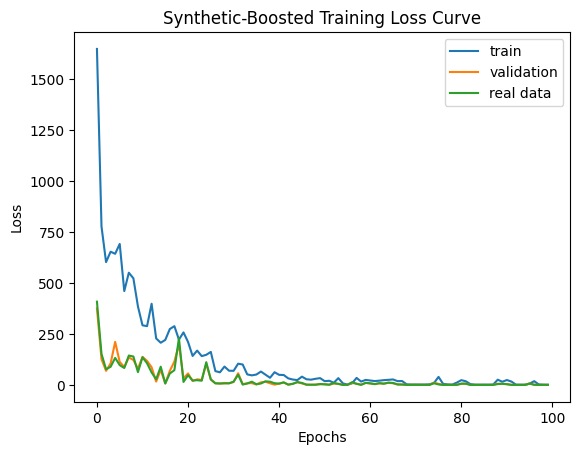

In [36]:
# Plot the synthetic loss curve
plt.plot(synth_train_loss_list, label="train")
plt.plot(synth_val_loss_list, label="validation")
plt.plot(synth_real_loss_list, label="real data")
plt.title("Synthetic-Boosted Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

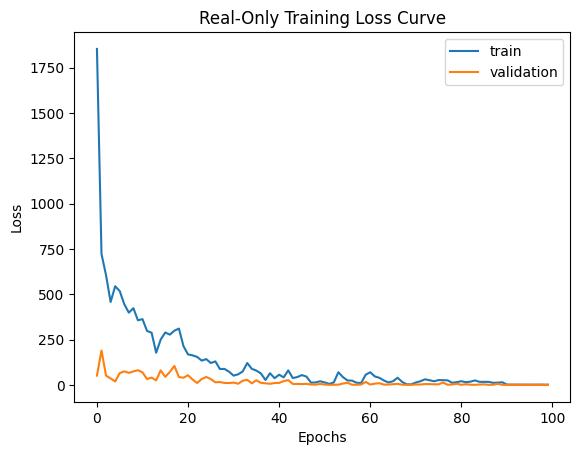

In [42]:
# Plot the real loss curve
plt.plot(real_train_loss_list, label="train")
plt.plot(real_val_loss_list, label="validation")
plt.title("Real-Only Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

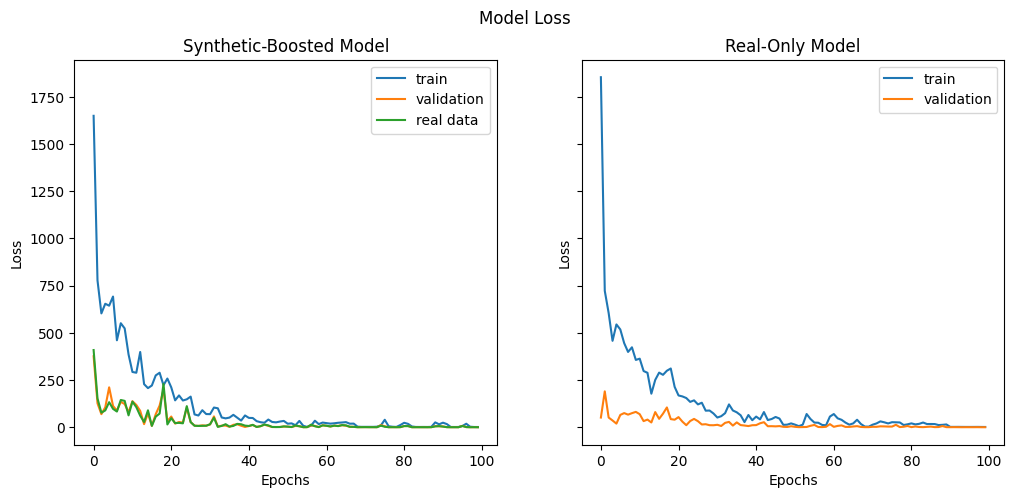

In [37]:
# Plot both loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
fig.suptitle('Model Loss')

ax1.plot(synth_train_loss_list, label="train")
ax1.plot(synth_val_loss_list, label="validation")
ax1.plot(synth_real_loss_list, label="real data")
ax1.set_title("Synthetic-Boosted Model")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(real_train_loss_list, label="train")
ax2.plot(real_val_loss_list, label="validation")
ax2.set_title("Real-Only Model")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()

plt.show()

In [40]:
# Save the models
torch.save(synth_model.state_dict(), 'models/synth_attack_classifier')
torch.save(real_model.state_dict(), 'models/real_attack_classifier')

# Model Evaluation

In [33]:
synth_model = Classifier(input_dim, hidden_dim, num_classes).to(device)
synth_model.load_state_dict(torch.load('models/synth_attack_classifier'))

real_model = Classifier(input_dim, hidden_dim, num_classes).to(device)
real_model.load_state_dict(torch.load('models/real_attack_classifier'))

<All keys matched successfully>

In [29]:
# Load real dataset
real_data = NFUQNIDS({'DDoS', 'Reconnaissance', 'Brute Force', 'Password', 'XSS', 'Backdoor'}, use_reduced=False, use_synthetic=False)
real_data = DataLoader(real_data, batch_size=batch_size, shuffle=True)

[[4.7289e+04 5.3000e+01 1.7000e+01 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [4.6808e+04 8.0000e+01 6.0000e+00 ... 1.0000e+00 1.0000e+00 0.0000e+00]
 [4.6810e+04 8.0000e+01 6.0000e+00 ... 1.0000e+00 1.0000e+00 0.0000e+00]
 ...
 [5.3284e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [4.2712e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [5.3286e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]]
[5 5 5 ... 3 3 3]


In [41]:
# Evaluation
synth_model.eval()
real_model.eval()
epochs = 10

with torch.no_grad():
    synth_metric = MulticlassAccuracy(num_classes=num_classes)
    real_metric = MulticlassAccuracy(num_classes=num_classes)
    synth_accuracy = 0
    real_accuracy = 0

    for i in tqdm(range(epochs)):
        epoch_synth_accuracy = 0
        epoch_real_accuracy = 0
        num = 0

        for inputs, labels in real_data:
            # Synth
            synth_outputs = synth_model(inputs)
            _, predicted = torch.max(synth_outputs, 1)
            synth_metric.update(predicted, labels)
            epoch_synth_accuracy += synth_metric.compute()

            # Real
            real_outputs = real_model(inputs)
            _, predicted = torch.max(real_outputs, 1)
            real_metric.update(predicted, labels)
            epoch_real_accuracy += real_metric.compute()

            num = num + 1

        synth_accuracy += (epoch_synth_accuracy / num) / epochs
        real_accuracy += (epoch_real_accuracy / num) / epochs

    print(f"Synthetic model accuracy: {synth_accuracy}")
    print(f"Real model accuracy: {real_accuracy}")

100%|██████████| 10/10 [09:09<00:00, 54.94s/it]

Synthetic model accuracy: 0.8747226595878601
Real model accuracy: 0.8915250301361084
